## References: http://www.cs.cornell.edu/info/courses/spring-98/cs522/content/lab4.pdf -->  FDF code

#### Fisher Black and Myron Scholes published their seminal work on option pricing in 1973. In it, they described a mathematical framework for calculating the fair price of a European option in which they used a no-arbitrage argument (perfect information within markets) to derive a partial differential equation which governs the evolution of the option price with respect to the time to expiry, $t$, and the price of the underlying asset, $S$. First, a brief description of options is warranted, followed by the derivation of, and assumptions underlying, the Black Scholes PDE. If we denote the current price of the underlying asset by S, then the payoffs at expiry, T, for a given exercise price, K, is given by: $$ Call(S,t) = max(S-K,0) $$ $$Pull(S,t) = max(K-S,0)$$K represents the fixed price at which the owner of the option can buy (call) or sell (put) the underlying security or commodity. Let's begin by constructing a portfolio, $\prod$, in which we are long one option, $V(S,t)$, and we are short an unknown quantity, $\Delta$ of the underlying quantity S. Therefore, $\prod = C - \Delta{S}$ Now, Black and Scholes advanced upon this step in a fairly creative manner by invoking the no-arbitrage principle. That is, the value of the portfolio must equal, on average, the value of the portfolio invested at the risk-free interest rate, $r$. The mathematical derivation aside, the BS partial differential equation is: $$ \frac{\delta{V}}{\delta{t}} + \frac{\sigma^{2}S^{2}\delta^{2}{V}}{2\delta{S}^{2}}+rS\frac{\delta{V}}{\delta{S}} - rV = 0  \space\space\space\space\space (1)$$
#### (Note this is technically a convection-diffusion equation, which is a type of second-order PDE) This simple PDE marks the evolution of any derivative whose underlying asset satisfies the Black-Scholes assumptions.

##### Let's implement the closed form solution for the exact value of equation (1) for a European calls and puts, assuming that dividends don't exist. This will be useful in finding the steady state equilbirium solution for an option with a specific underlying asset price, in combination with a Strike Price (K), Implied Volatility ($\sigma$) and Time till expiration (T) that we shall later vary. For call and put options respectively, the formulae are: $$V(S_t,t) = S_{t}N(d_1) - Ke^{-rT}N(d_2) \space\space\space(Call Option)$$$$V(S_t,t) = Ke^{-rT} N(d_1) - S_{t} N(d_2)\space\space\space(Put Option)$$ where $d1 = \frac{ln(\frac{S_t}{K}) + (r + \frac{\sigma^{2}}{2})}{\sigma\sqrt{T}}$ and $d2 = d1 - \sigma\sqrt{T}$ where N is a function representative of the standard normal distribution. This expression represents equation $(2)$.

In [1]:
from scipy.stats import norm #instead of trying to approximte the normal distribution, use scipy
from scipy import *
import numpy as np
def bs_exact(type,S,T,K,r,sigma):
    d1 = (np.log(float(S)/K)+((r)+(sigma**2/2.))*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    if (type == 'call') or (type == 'Call'):
        return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    elif (type == 'put') or (type == 'Put'):
        return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

Why is this expression useful? Well, the list of options for a stock at any given day are such that the risk-free interest rate and time to expiry are the same, while there are multiple strike prices. Hence, for varying rates of implied volatility and strike price, we can find the fair values of the corresponding options.
Let's run some tests of the stability of these 'exact' solutions by seeing how they hold up against different strike prices.

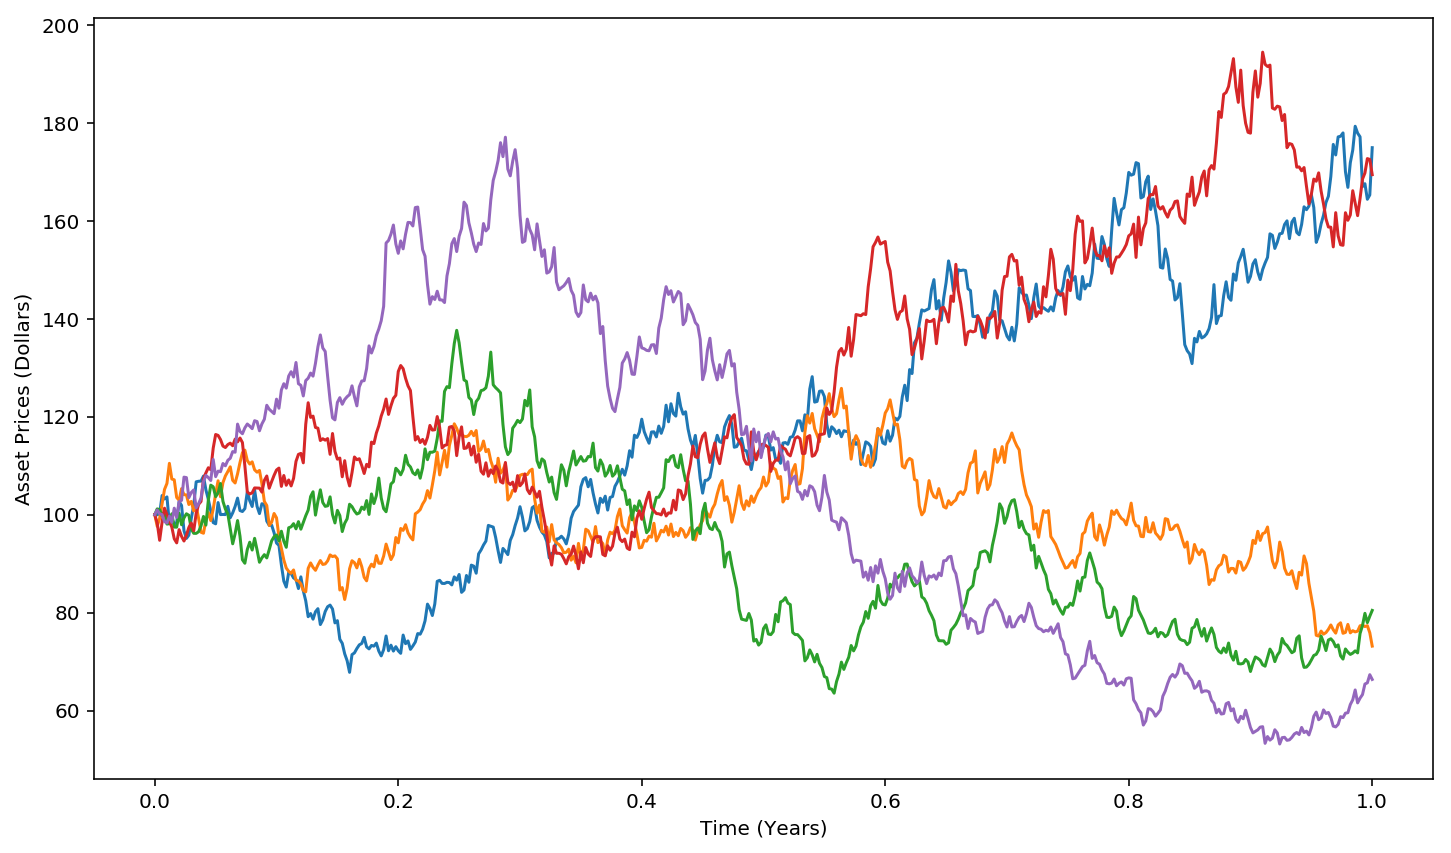

In [2]:
def bs_exact_graph(S0, m, mu, sigma, T, lines):
    import matplotlib.pyplot as plt
    S = empty(shape=(m+1,lines))
    t = np.linspace(0,T,m+1)
    h = T/np.float(m) #step size in time
    S[0] =S0 #fill the first row with the underlying price of the asset, which we'll use to populate matrix S
    for i in np.arange(1,m+1):
        S[i]=S[i-1]*(1+mu*h+sigma*np.sqrt(h)*randn(lines))
    plt.plot(t,S)
    plt.xlabel('Time (Years)')
    plt.ylabel('Asset Prices (Dollars)')
    plt.show('Underlying price of asset')
bs_exact_graph(S0=100,m=500,mu=0.1,sigma=0.5,T=1,lines=5)

/ext/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


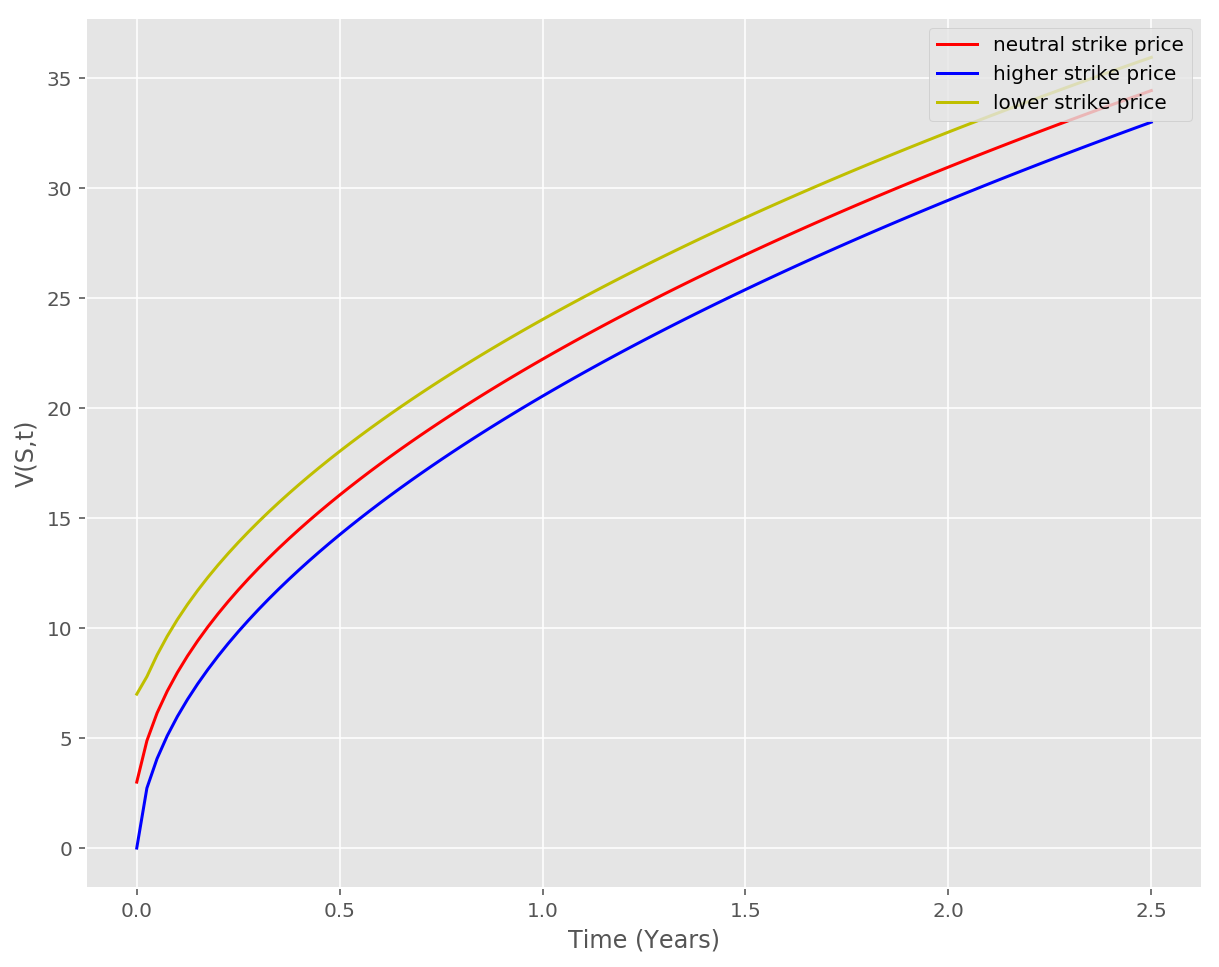

In [3]:
## Vary the strike price over a certain time interval
K=97
T=2.5
S0=100
r=0.03
sigma=0.5
t = np.linspace(0,T,100+1)
t2 = np.linspace(T,T+0.5,100+1)
c1 = []
c2 = []
c3 = []
for i in t:
    c1.append(bs_exact('call',S0,i,K,r,sigma)) 
    c2.append(bs_exact('call',S0,i,K+4,r,sigma))
    c3.append(bs_exact('call',S0,i,K-4,r,sigma))
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

plt.style.use('ggplot')
plt.figure()
plt.plot(t,c1,'r',label = 'neutral strike price')
plt.plot(t,c2,'b',label = 'higher strike price')
plt.plot(t,c3,'y', label = 'lower strike price')
plt.xlabel('Time (Years)')
plt.ylabel('V(S,t)')
plt.legend(loc = 1)
plt.show()

$V(S, t)$ shifts upwards in a parallel fashion for lower strike prices, and vice versa. So far, the analytical solution is consistent with real option pricing.

Text(0,0.5,'V(S,t)')

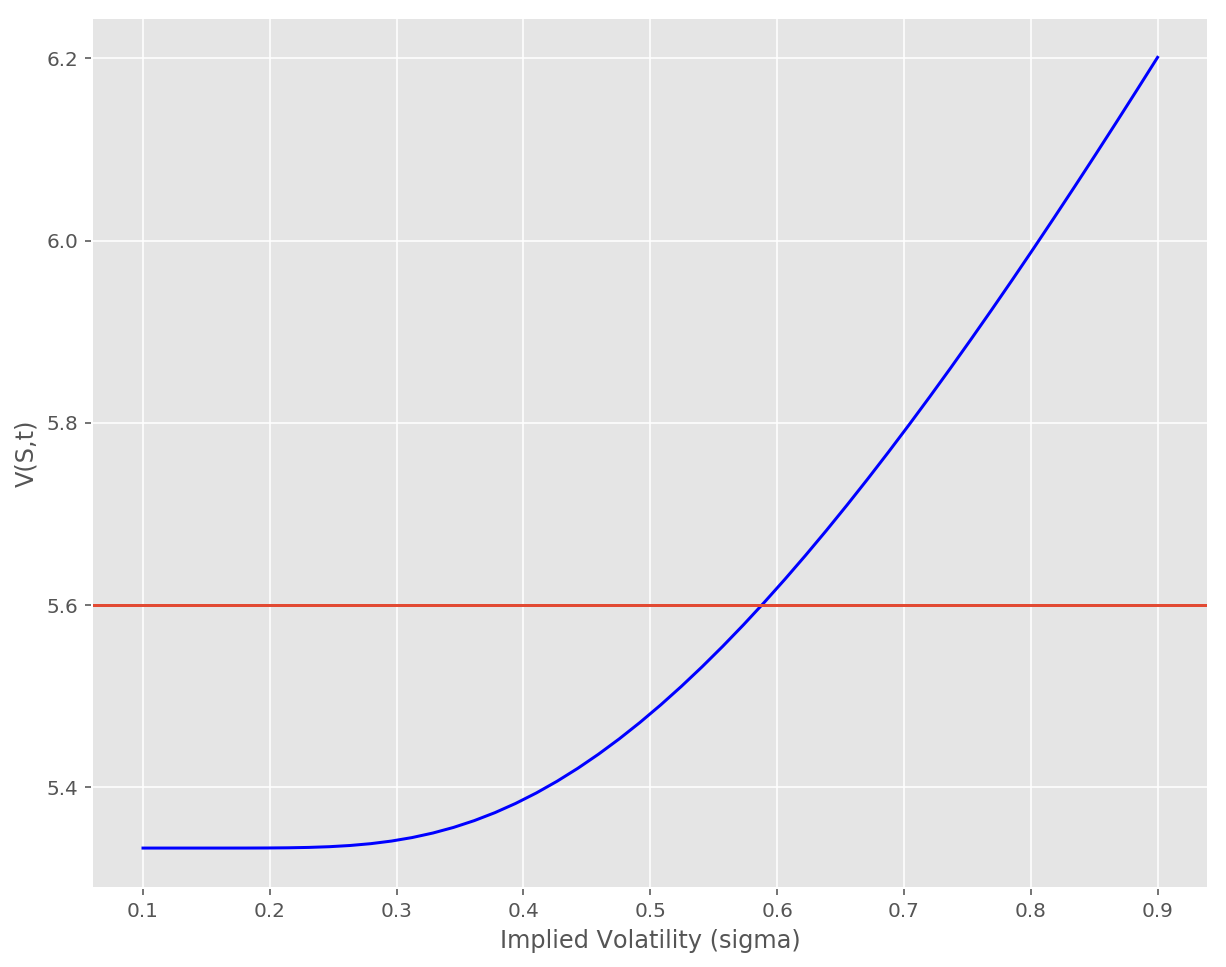

In [4]:
#Let's use data for cisco's options and stock price to see if there is one implied volatility which is correct in deriving the actual fair value of the option.
K = 11
T = 1/3
S0 = 16.26
r = 0.02
sigma = np.linspace(0.1,0.9)
calls = []
for s in sigma:
    calls.append(bs_exact('call',S0,T,K,r,s))
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

plt.style.use('ggplot')
plt.figure()

plt.plot(sigma,calls,'b')
plt.axhline(5.6) #actual price of stock
plt.xlabel('Implied Volatility (sigma)')
plt.ylabel('V(S,t)')
#idx = np.argwhere(np.diff(np.sign(calls - 5.6)) != 0)
#We can eyeball the intersection occurs at an implied volatility close to 0.59
#However, we observe that different strike prices also have different implied volatilities, in an option chain for an asset.

#### Once again, the volatility we derive ($0.5898$) is very close to the actual implied volatilty of the stock ($0.58$), at the fixed actual fair value of the asset. But, even though we may be confident in the assumptions of the Black-Scholes model, the analytical solution derived above falls short at the point where it estimates different volatilities for different strike prices, for options with a fixed risk-free interest rate and time to maturity, hence we need a better model for pricing real options. While Fourier Transforms, Monte Carlo Methods, and integrators are used in contemporary literature on real option pricing, I shall use Finite Difference Methods to approximate the fair value of options.

#### The idea underlying Finite differences method is to replace the derivatives, which are some functional limit in the language of analysis, with approximations corresponding to small values between each step size in time and asset price. As an overview, one employs a backwards 'time-marching' approach where a known approximate solution at time $t = T$ (the expiry of the option), is used to approximate a new solution at a stepped time, $t = T-1$, and then interate this process till one calculates the approximate solution when $t = 0$ to retrieve present day fair value of the option price. Hence, we can discretize (1) to a two-dimensional grid of time, in terms of years, and the underlying value of the asset. 
![discretization image](https://quintus-zhang.github.io/post/on_pricing_options_with_finite_difference_methods/boundary_conditions.png) 
#### $S$ represents the underlying price of the asset in present day, so we'll use to $x$ to represent the discretization of asset prices. Hence, we need $x_{max}$, which is the underlying price of the asset unlikely to be reached, and for the remaining mesh-points, $$ t = 0,\delta{t},2\delta{t},3\delta{t},...,m\delta{t}$$ and $$x=0,\delta{x},2\delta{x},...,n\delta{x}$$  
#### $\delta{t}$ and $\delta{S}$ are the mesh sizes, and for each node $i\delta{S}$ and $j\delta{t}$, we use the grid notation $$V(m,n) = V(m\delta{x},n\delta{t})$$ For this, we fix the values of $x$ we are interested in, say $x_{min}$ and $x_{max}$, the number $m$ of subintervals of time period: $[0,T]$, and the number, $n$ of subintervals we use in the $x$ direction. We pick these boundaries on $x$ so simple boundary conditions may be implemented so . The final condition (or initial condition depending on one's perspective) is calculated at $t = T$ such that $V_{i,m} = maximum(x_{i} - K, 0)$ where $i = 1,2,...,n$. Then one implements the Dirichlet boundary condition (for purposes of simplicity) at $V_{0,k}$ and $V_{n,k}$, ($k=1,2,....,m-1$) which are equal to $maximum(x_{max} - K,0)$ and $maximum(0,x_{min}-K)$ respectively to calculate the values at the $0th$ and $nth$ rows. This means we have to use the PDE to derive $(n-1)*m$ additional equations for the unknown values. Skipping the remainder of the derivation of this method, which is described [here](http://dspace.ut.ee/bitstream/handle/10062/22466/ComputationalFinance_materjalid.pdf), the algorithm for the explicit FDF is $$ U_{i,k-1} = a_{ik}*U_{i-1,k} + b_{ik}*U_{i,k} + c_{ik}*U_{i+1,k} \space\space(3)$$ and  $i = 1,2,...,n-1$ and $k = 1,2,..,m $ where $ a_{i,k} = (\frac{\delta{t}}{\delta{x^{2}}})(\alpha_{i,k}-\frac{\beta_{i,k}\delta{x}}{2})$, $b_{i,k} = 1 - 2\frac{\delta{t}}{\delta{x^{2}}}\alpha_{i,k} - r\delta{t}$, $c_{i,k} = \frac{\delta{t}}{\delta{x^{2}}}(\alpha_{i,k}+\frac{\beta_{i,k}\delta{x}}{2})$

In [5]:
#Explicit FDF
from scipy import *
import numpy as np
def p_call(s):
    return (max(s-K,0))
        #d1 = (np.log(float(S0)/K)+((r)+(sigma**2/2.))*T)/(sigma*np.sqrt(T))
        #d2 = d1-sigma*np.sqrt(T)
        #return S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
def phi1_call(t,xmin):
    return(p_call(np.exp(xmin)))
def phi2_call(t,xmax):
    return (p_call(np.exp(xmax)))
def bs_explicit(S0,rho,T,n,K,r,sigma,phi1,phi2,p):
    xmin=np.log(S0/float(rho))
    xmax=np.log(S0*rho)
    dx=(xmax-xmin)/n
    m= np.int(T*(sigma**2/dx**2+r))
    x=np.linspace(xmin,xmax,n+1)
    dt=T/float(m)
    V=np.zeros((n+1,m+1))
    alpha=sigma**2/2
    beta=r-alpha
    a=(dt/dx**2)*(alpha-(beta/2)*dx)
    b=1-(2*dt/dx**2)*alpha-(r*dt)
    c=(dt/dx**2)*(alpha+(beta/2)*dx)
    t=linspace(0,T,m+1)
    i=np.arange(1,n)
    #final condition
    V[:,m]=x-K
    mask = (V[:,m] < 0)
    V[mask,m]=0
    for k in np.arange(m,0,-1):
         #boundary conditions
        V[0,k-1]=phi1(t[k-1],xmin)
        V[n,k-1]=phi2(t[k-1],xmax)
        V[i,k-1]=a*V[i-1,k]+b*V[i,k]+c*V[i+1,k] #Finally, the explicit method itself for all values barring those at boundaries
    return([V[:,0],np.exp(x)])

Let's compare the analytical solutions to those from the explicit FDF.

/ext/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/ext/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


10.2355341156
28.7865747055


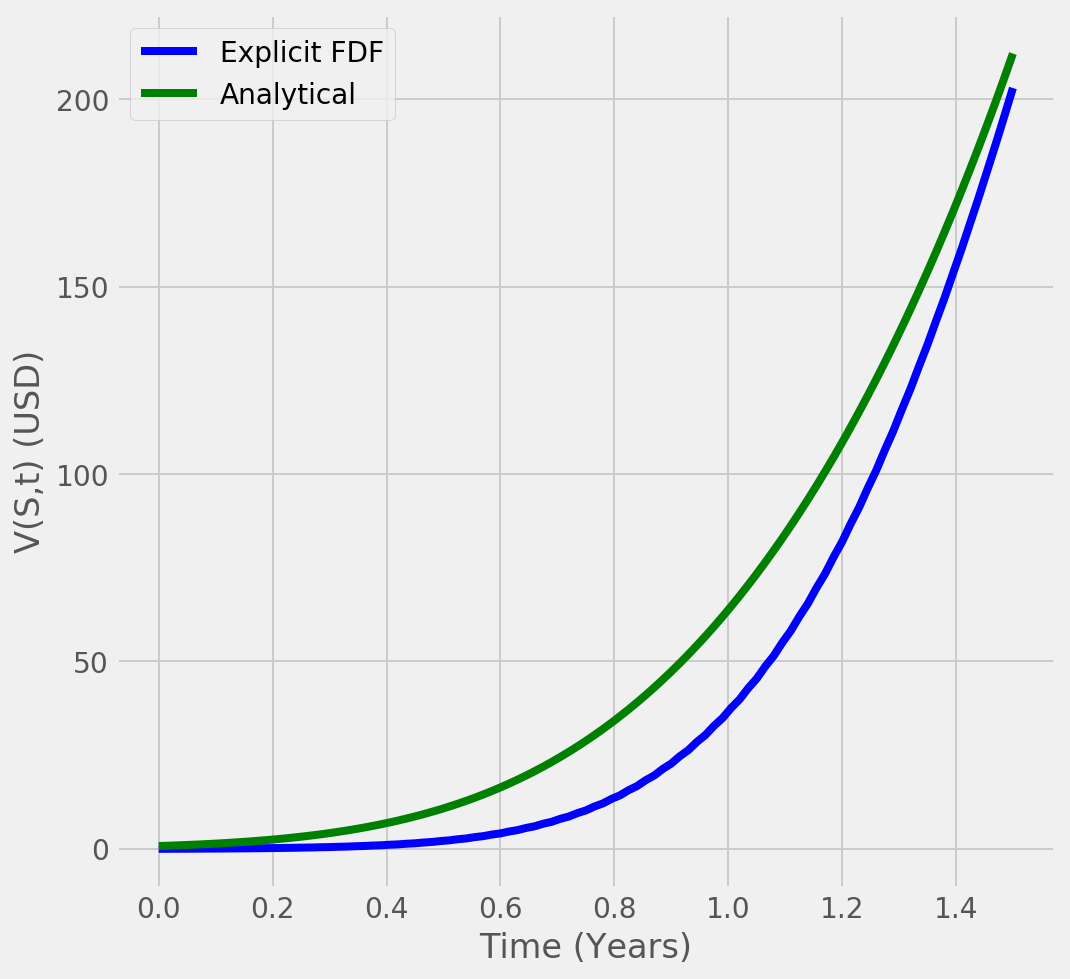

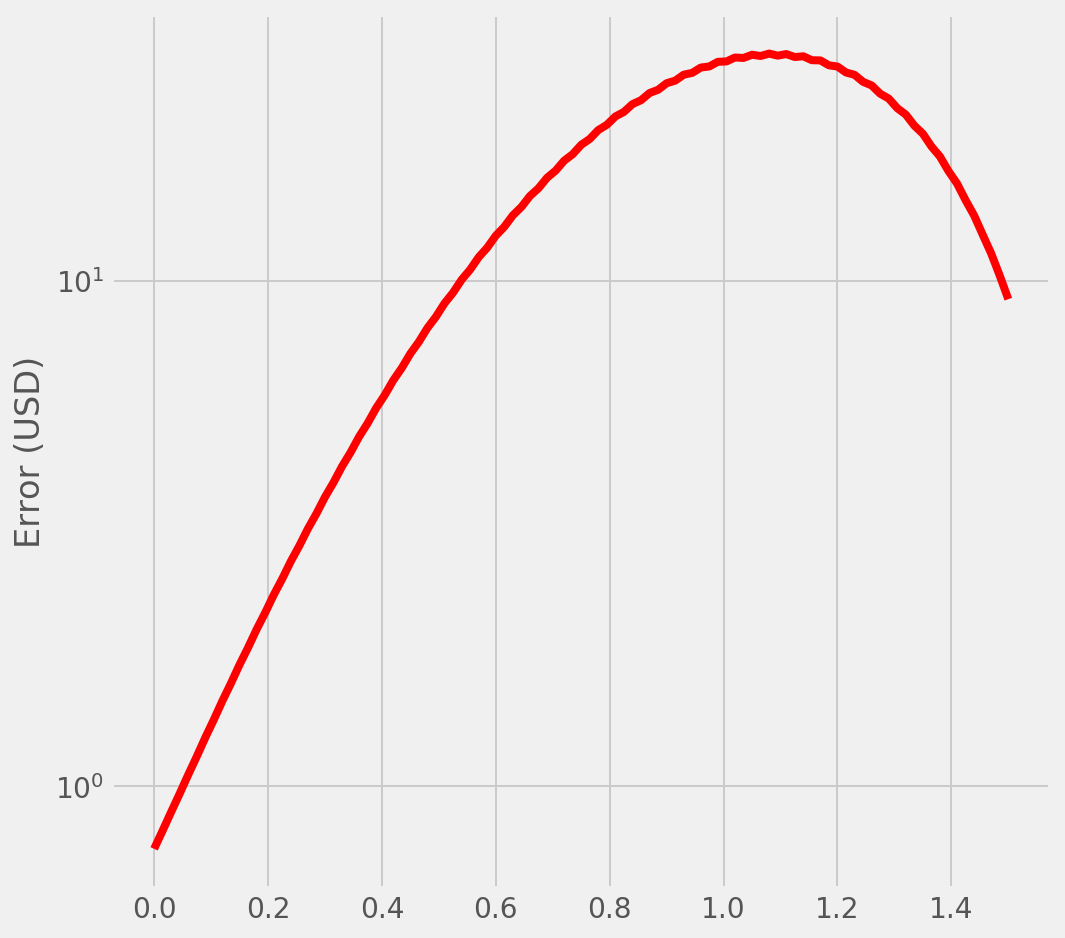

In [6]:
#example data typically used a to describe a vanilla European option.
K=97
T=1.5
S0=100
r=0.06
rho=3
sigma=0.5
n=100
answer= bs_explicit(S0,rho,T,n,K,r,sigma,phi1_call,phi2_call,p_call)
approx = answer[0]
S = answer[1]
# Using the matrix of discretized values of S, one can retrieve exact solutions
# for each asset price, and the example parameters above, to compare against the solutions from 
# the explicit FDF
exact = np.zeros(n+1) #create empty matrix to store in exact solutions
for i in range(n+1):
    exact[i] = bs_exact('call',S[i],T,K,r,sigma)
# bs_exact('call',S,T,K,r,sigma)
error = exact - approx
#print(exact)
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7.5, 7.5)
plt.style.use('fivethirtyeight')
plt.figure()
discretized_time = np.linspace(0,T,n+1)
plt.plot(discretized_time,approx,'b',label='Explicit FDF')
plt.plot(discretized_time,exact,'g',label='Analytical')
plt.xlabel('Time (Years)')
plt.ylabel('V(S,t) (USD)')
plt.legend(loc = 'upper left')
#error_graph
plt.figure()
plt.semilogy(discretized_time,error,'r')
plt.ylabel('Error (USD)')
print(approx[n/2]) #the fair value price we were seeking with respect to the value of S0
print(exact[n/2])

### This example illustrates the FDF underestimates the fair value of the option price computed by the analytical solution, and this disparity worsens as it marches further and further back in time towards the value corresponding to the underlying price of the asset. Clearly, this numerical approximation is not as precise compared to ones studied this semester.

#### Now, I need to retrieve live financial information for options, based on fixed values of time till maturity, to use as sample arguments in order to test this method's efficacy. Luckily I can also retrieve the last price (including bids and asks), as a realistic standard of comparison against the singular output of the methods below to ascertain this fair value.

In [7]:
#Create function to retrieve option for a fixed date till maturity
import numpy as np
from pandas_datareader.data import Options
from pandas_datareader.data import DataReader
import pandas as pd
from datetime import datetime
import json
def option_fixed_time(asset,expiry):  #,asset_price):
    actual_prices = []
    #df = pd.DataFrame(columns = columns) #initialize an empty dataframe to store values in later
    #try one option chain
    start = datetime(2017, 11, 27)
    end = datetime(2017, 11, 28)
    try:
    #need a try-except block
        stock_price = DataReader(asset.upper(),'yahoo')
    except RemoteDataError:
        pass
        #print('couldnt connect to yahoo finance, try again') #need a smarter way to program this
    S = stock_price['Adj Close'][-1] #Retrieve today's price #Note there is only one stock price regardless of your time of expiration of interest
    #So, we can get the underlying value of the asset right away, in order to get the other arguments, we shall fix the date of         expiration and get a list of 6 options at a time with different 'actual prices', strike prices (K), and implied vols.                 (Sigma).
    #Then retrieve options data using Options() from pandas
    options = Options(asset, 'yahoo')
    expiry = datetime(2017+expiry, 1, 18)
    data_fixed_t = options.get_call_data(expiry = expiry)  #18th Jan 2019, so expires in approximately 14 months
    for i in range(0,11):
        json_dict = (data_fixed_t["JSON"][i])
        #Get 5 inputs for the solutions to B&S model
        exact_live = json_dict['lastPrice']
        K = json_dict['strike']
        #therefore the time till maturity is:
        T = 14/12.0  #since the date of expiration is in units of years
        sigma = json_dict['impliedVolatility']
        r = 0.0201 #November 2017 5-year Treasury Bill rate (retrieved from https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield)
#         ee_price = bs_explicit(S,M,T,N,K,r,sigma) #price estimation according to explicit FD method
        
#         actual_prices.append(np.array([actual_price]))
#         ee_prices.append(np.array([ee_price]))
        #a.append(np.array([S,K,T,sigma,r,actual_price])) #6 entries per row
    arguments = S,T,K,r,sigma
    return arguments, exact_live

In [8]:
def bs_graph_exact_fdf(asset):
    results = option_fixed_time(asset,1)
    a = results[0]
    rho = 3
    n = 100
    answer = bs_explicit(a[0],rho,a[1],n,a[2],a[3],a[4],phi1_call,phi2_call,p_call)
    approx = answer[0]
    S = answer[1]
    exact = np.zeros(n+1) #create empty matrix to store in exact solutions
    for i in range(n+1):
        exact[i] = bs_exact('call',S[i],T,K,r,sigma)
    error = exact - approx
    plt.rcParams['figure.figsize'] = (7.5, 7.5)
    plt.style.use('fivethirtyeight')
    plt.figure()
    discretized_time = np.linspace(0,T,n+1)
    plt.plot(discretized_time,approx,'b',label='Explicit FDF')
    plt.axhline(results[1])
    plt.plot(discretized_time,exact,'g',label='Analytical')
    plt.xlabel('Time (Years)')
    plt.ylabel('V(S,t)')
    plt.legend(loc = 'upper left')
    #error_graph
    plt.figure()
    plt.semilogy(discretized_time,error,'r')
    plt.ylabel('Error (USD)')
    print('FDF fair value of option, with respect to the corresponding value of S0:','',approx[n/2])
    print('Exact value of option, with respect to the corresponding value of S0:','',exact[n/2])
    print('Actual value of option from finance.yahoo.com:','',results[1]) #actual option value on yahoo finance

/ext/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/ext/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


FDF fair value of option, with respect to the corresponding value of S0:  119.429526491
Exact value of option, with respect to the corresponding value of S0:  106.685960422
Actual value of option from finance.yahoo.com:  165.7


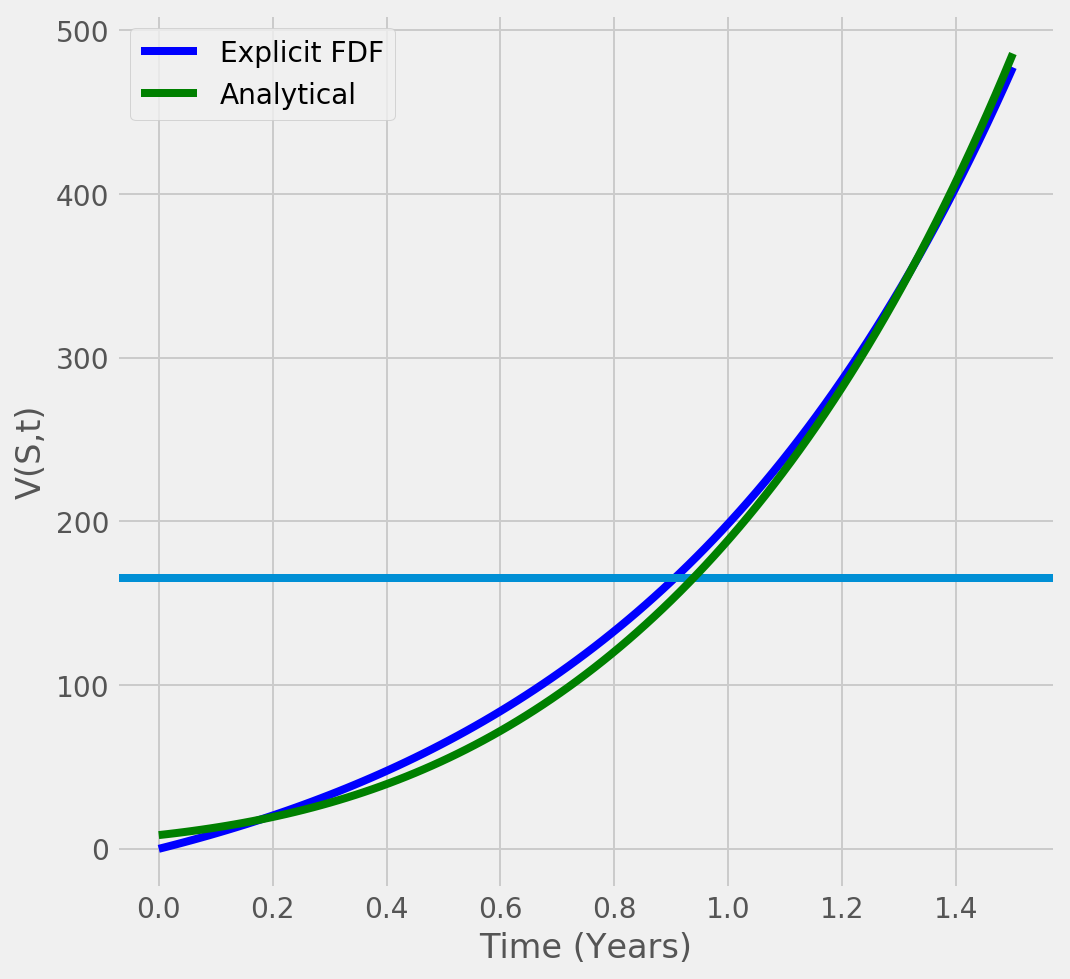

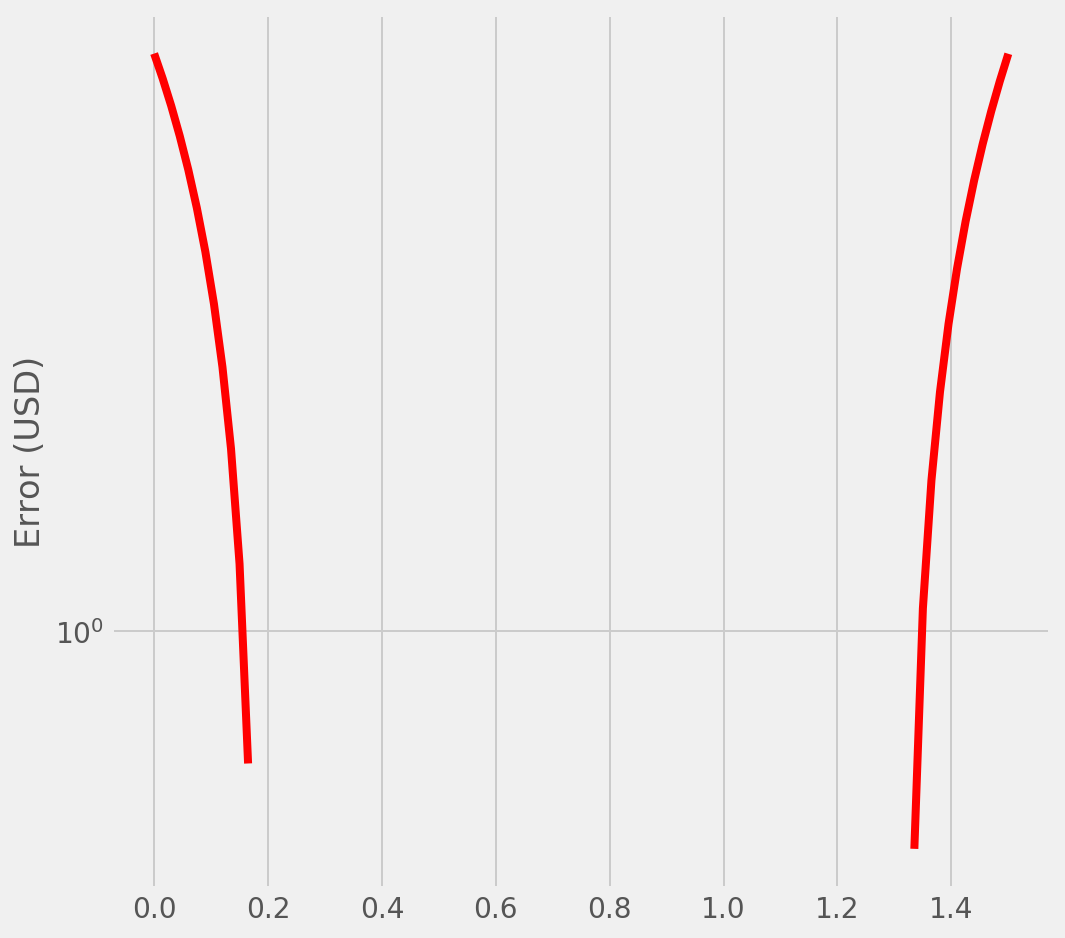

In [12]:
bs_graph_exact_fdf('nvda')

#### While not incredibly different, using live prices for actual commodities, specifically NVDIA stock in this case seems to bring the numerical and analytical solutions closer together. As a thought experiment, when I selected stock tickers for companies with very cut and dry options, like technology companies, the estimations above faired better than those for companies within the financial sector, like Bank of America.

#### However, varying different commodities for present-day markets are not very illustrative of the precision of the Explicit FDF, in comparison to the Analytical Solution. Let's see how these methods approximate the fair value, while steadily varying the underlying price of the asset.

Text(0.5,0,'Asset Price (USD)')

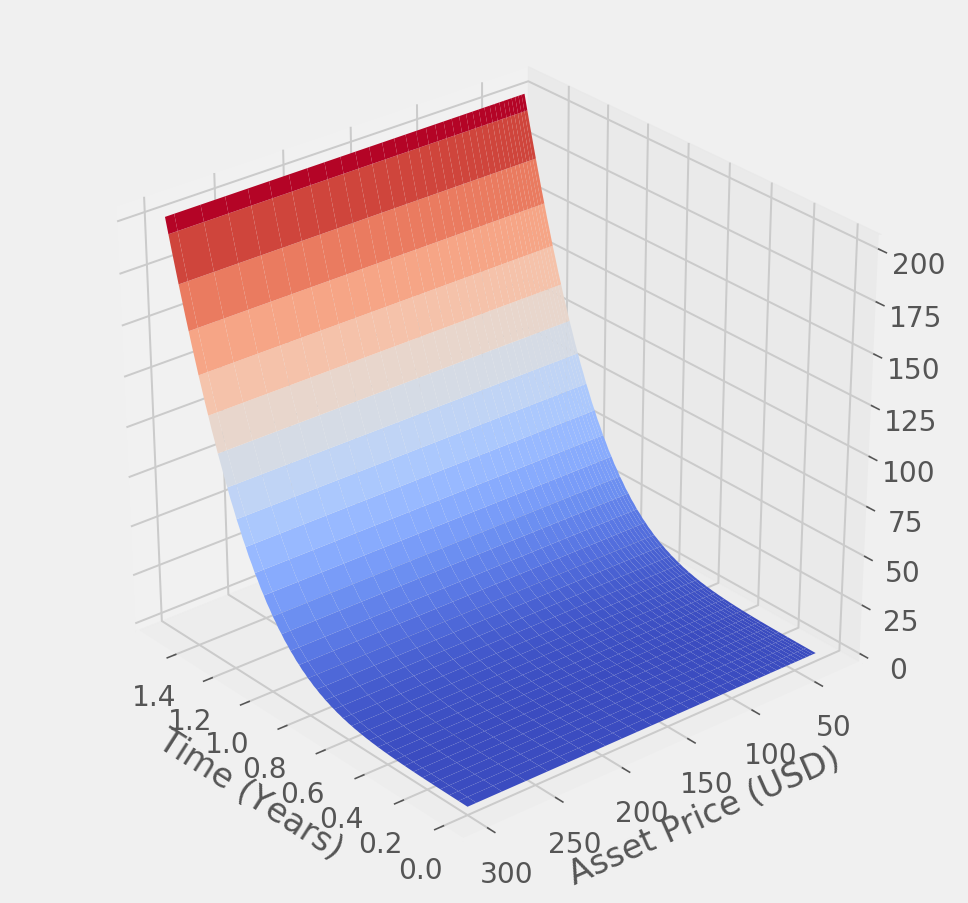

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
K=97
T=1.5
#S0=np.arange(100,201,1)
S0 = 100
r=0.06
rho=3
sigma=0.5
n=100
discretized_time=np.linspace(0,T,n+1)
#discretized_space=np.linspace()
#answers = [bs_explicit(S0[i],rho,T,n,K,r,sigma,phi1_call,phi2_call,p_call)[0][n/2] for i in range(len(S0))]
answers = bs_explicit(S0,rho,T,n,K,r,sigma,phi1_call,phi2_call,p_call)
Z,Y=np.meshgrid(answers[0],answers[1])
X,Y=np.meshgrid(discretized_time,answers[1])
# X, Y = np.meshgrid(discretized_time, S0)
# Z1 , Z2 = np.meshgrid(discretized_time, answers)
# np.shape(discretized_time)
fig = plt.figure()
ax = fig.gca(projection='3d')
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     ax.plot_surface(X,Y,Z,cmap = cm.coolwarm)
#     plt.pause(0.1)
ax.view_init(30,140)
ax.plot_surface(X,Y,Z,cmap = cm.coolwarm)
#plt.savefig("movie%d.png" % ii)
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price (USD)')
#Fair Value on the Z-Axis
#fig.colorbar(surf, shrink=0.7, aspect=11)
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [0]:
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# K=97
# T=1.5
# S0=np.arange(100,201,1)
# r=0.06
# rho=3
# sigma=0.5
# n=100
# discretized_time=np.linspace(0,T,n+1)
# answers = [bs_explicit(S0[i],rho,T,n,K,r,sigma,phi1_call,phi2_call,p_call)[0][n/2] for i in range(len(S0))]
# X, Y = np.meshgrid(discretized_time, S0)
# Z1 , Z2 = np.meshgrid(discretized_time, answers)
# np.shape(discretized_time)
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# #ax.plot_surface(X,Y,Z1)
# ax.plot_surface(X,Y,Z2,cmap = cm.coolwarm)
# plt.xlabel('Time (Years)')
# plt.ylabel('Asset Price (USD)')
# #Fair Value on the Z-Axis

In [0]:
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# K=97
# T=1.5
# S0=np.arange(100,201,1)
# r=0.06
# rho=3
# sigma=0.5
# n=100
# discretized_time=np.linspace(0,T,n+1)
# answers = [bs_explicit(S0[i],rho,T,n,K,r,sigma,phi1_call,phi2_call,p_call)[0] for i in range(len(S0))]
# # np.shape(answers[3])
# X, Y = np.meshgrid(discretized_time, S0)
# Z1 , Z2 = np.meshgrid(discretized_time, answers[7])
# np.shape(discretized_time)
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# #ax.plot_surface(X,Y,Z1)
# ax.plot_surface(X,Y,Z2,cmap = cm.coolwarm)
# plt.xlabel('Time (Years)')
# plt.ylabel('Asset Price (USD)')
# #Fair Value on the Z-Axis